<a href="https://colab.research.google.com/github/irodcast/GD_HW/blob/master/disease_spread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

print(f'PyTorch version: {torch.__version__}')

if torch.cuda.is_available()==True:
    use_cuda = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')

PyTorch version: 1.3.1+cu100
GPU available: Tesla P100-PCIE-16GB (1 count)


In [0]:
def default_device():
    if torch.cuda.is_available()==True:
        dflt_device = torch.device('cuda')
    else:
        dflt_device = torch.device('cpu')

    return dflt_device

dflt_device = default_device()

In [0]:
def create_dataset(dir_in_str, dflt_device, testset_size=200):
    dataset_np = np.load(dir_in_str)
    dataset_py = torch.from_numpy(dataset_np).transpose(1,0)
    X_train = Variable(dataset_py[:-testset_size,0:-1,:]).to(device=dflt_device)
    Y_train = Variable(dataset_py[:-testset_size,1:,:]).to(device=dflt_device)
    dataset_test = Variable(dataset_py[-testset_size:,:,:]).to(device=dflt_device)
    
    return X_train, Y_train, dataset_test


class Net(torch.nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size, linear_output_size, num_lstm_layers):
        super(Net, self).__init__()
        self.lstm_input_size     = lstm_input_size
        self.lstm_hidden_size    = lstm_hidden_size
        self.linear_output_size  = linear_output_size
        self.num_lstm_layers     = num_lstm_layers
        
        self.lstm   = torch.nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, \
                                    self.num_lstm_layers, batch_first=True, bidirectional=False)
        self.linear = torch.nn.Linear(self.lstm_hidden_size, self.linear_output_size)
        
        
    def forward(self, lstm_input, prev_hidden):
        lstm_output, lstm_hidden = self.lstm(lstm_input, prev_hidden)
        linear_output = self.linear(lstm_output)
        #Y_hat = torch.sigmoid(linear_output)
        
        return linear_output, lstm_hidden
    

def predict_seq(x, timesteps):
    numNodes = x.size(0)
    Y_pred = torch.zeros(timesteps, numNodes).to(device=dflt_device)
    Y_pred[0, :] = x.view(1, numNodes)
    prev_hidden = (torch.zeros(num_lstm_layers, 1, lstm_hidden_size).to(device=dflt_device),\
              torch.zeros(num_lstm_layers, 1, lstm_hidden_size).to(device=dflt_device) )
    
    x_ini  = x.view(1, 1, -1)
    mask_py = torch.ones(x.shape).to(device=dflt_device)
    x_prev = x_ini
    for step in range(1, timesteps):
        x_next, next_hidden = forward_pass(x_prev, prev_hidden)
        x_next = torch.min(x_next + x_ini, mask_py)
        Y_pred[step,:] = x_next.view(1, numNodes)
        x_prev = x_next
        prev_hidden = next_hidden

    Y_pred   = Y_pred.cpu()    
    Y_pred   = Y_pred.detach().numpy()
    mask_np  = np.ones(Y_pred.shape)
    masked_Y = np.minimum(Y_pred, mask_np)
    
    return masked_Y

def compare_bars(example_num):   
    Y_true = dataset_test[example_num, :, :].detach().cpu()
    Y_true = Y_true.detach().numpy()
    num_timesteps = Y_true.shape[0]
    Y_pred = predict_seq(dataset_test[example_num,0,:], num_timesteps)
    bin_idxs = Y_pred[0,:].shape[0]
    cumulative_error = 0
    for day in range(num_timesteps):
        plt.figure(figsize=(10,10))
        plt.bar(np.arange(bin_idxs), height=Y_pred[day,:], alpha=0.9, color='yellow', label='Predicted')
        plt.bar(np.arange(bin_idxs), height=Y_true[day,:], alpha=0.4, color='blue', label='True')
        plt.legend(loc='best')
        plt.show()
        error = np.sum(np.abs(Y_true[day,:] - Y_pred[day,:]))*100/num_nodes
        cumulative_error += error
        if day==0:
          print(f'Initial infected nodes')
        if day>0:
          print(f'Error from day {day} to day {day+1}: {round(error, 2)} %')

    print('----------------------------------------------------------------------------')
    print(f'Average error day by day: { round(cumulative_error/(num_timesteps-1), 2) } %')



In [0]:
X_train, Y_train, dataset_test = create_dataset('Train.npy', dflt_device, testset_size=100)
#Experiment with tiny dataset:
#X_train = X_train[0:6,:,:]
#Y_train = Y_train[0:6,:,:]

In [0]:
torch.manual_seed(12)

num_examples, num_timesteps, num_nodes = X_train.size()
num_lstm_layers  = 1
lstm_hidden_size = 256
LR          = 0.005
epochs      = 15000
WeightDecay = 1e-8
Momentum    = 0.9

forward_pass = Net(num_nodes, lstm_hidden_size, num_nodes, num_lstm_layers)
forward_pass = forward_pass.to(device=dflt_device)
initHidden = (torch.zeros(num_lstm_layers, num_examples, lstm_hidden_size).to(device=dflt_device),\
              torch.zeros(num_lstm_layers, num_examples, lstm_hidden_size).to(device=dflt_device) )

loss_func    = torch.nn.MSELoss()
#loss_func    = torch.nn.BCEWithLogitsLoss()
optimizer    = torch.optim.Adam(forward_pass.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8, weight_decay = WeightDecay )
#optimizer    = torch.optim.RMSprop(forward_pass.parameters(),lr=LR, alpha=0.99, eps=1e-8, weight_decay = WeightDecay, momentum = Momentum, centered=True)
#scheduler    = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001, last_epoch=-1)

num_parameters = sum([p.numel() for p in forward_pass.parameters()])
print(f'Number of training examples: {num_examples}')
print(f'Number of trainable parameters: {num_parameters}')

Number of training examples: 3900
Number of trainable parameters: 392292


Epoch: 50, Loss: 0.013551853597164154  (Learning rate: [0.004999862950829098])
Epoch: 100, Loss: 0.012696689926087856  (Learning rate: [0.004999451818345376])
Epoch: 150, Loss: 0.011410119943320751  (Learning rate: [0.004998766647634146])
Epoch: 200, Loss: 0.009528842754662037  (Learning rate: [0.004997807513832097])
Epoch: 250, Loss: 0.006935972720384598  (Learning rate: [0.004996574522119057])
Epoch: 300, Loss: 0.004598254803568125  (Learning rate: [0.004995067807706465])
Epoch: 350, Loss: 0.003077172441408038  (Learning rate: [0.004993287535822533])
Epoch: 400, Loss: 0.002170602325350046  (Learning rate: [0.004991233901694136])
Epoch: 450, Loss: 0.0018150759860873222  (Learning rate: [0.0049889071305253985])
Epoch: 500, Loss: 0.001410146476700902  (Learning rate: [0.004986307477472999])
Epoch: 550, Loss: 0.001191801973618567  (Learning rate: [0.00498343522761819])
Epoch: 600, Loss: 0.001004628837108612  (Learning rate: [0.0049802906959355376])
Epoch: 650, Loss: 0.0009651446016505361

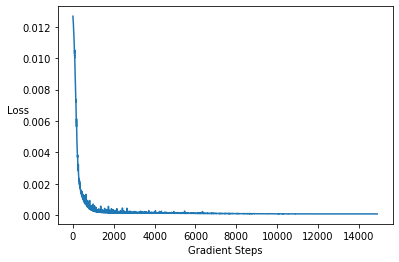

In [0]:
torch.manual_seed(1)

loss_hist  = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    Y_hat, _ = forward_pass(X_train, initHidden)
    Loss = loss_func(Y_hat,Y_train)
    Loss.backward()
    optimizer.step()
    loss_hist.append(Loss.item())
    scheduler.step()
    if epoch%50==0:
      print(f'Epoch: {epoch}, Loss: {Loss}  (Learning rate: {scheduler.get_lr()})')
    
plt.plot(loss_hist[100:])
plt.xlabel('Gradient Steps')
vert_label=plt.ylabel('Loss')
vert_label.set_rotation(0)

In [0]:
compare_bars(3)

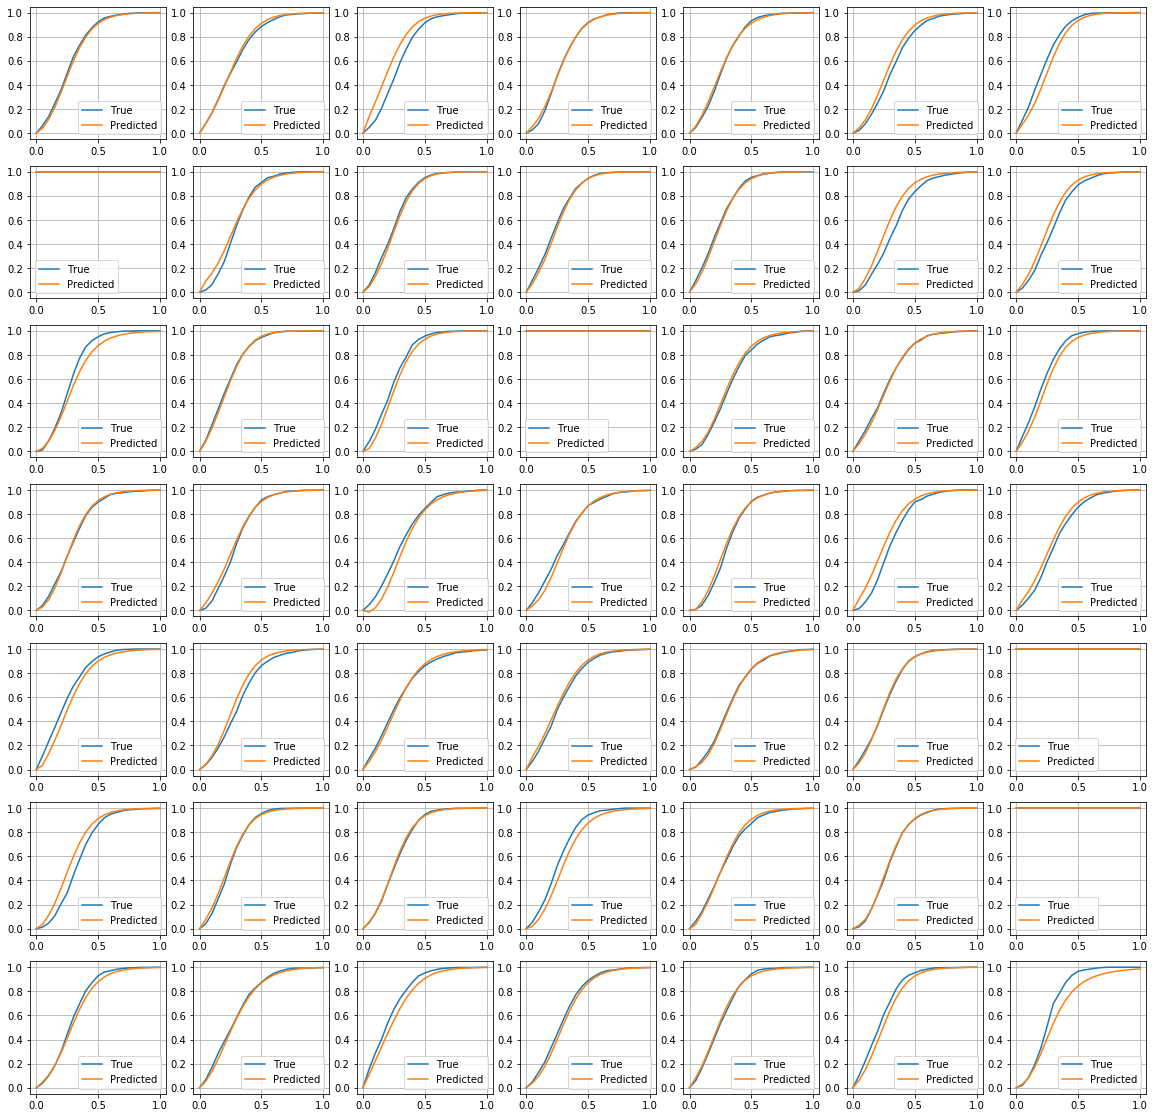

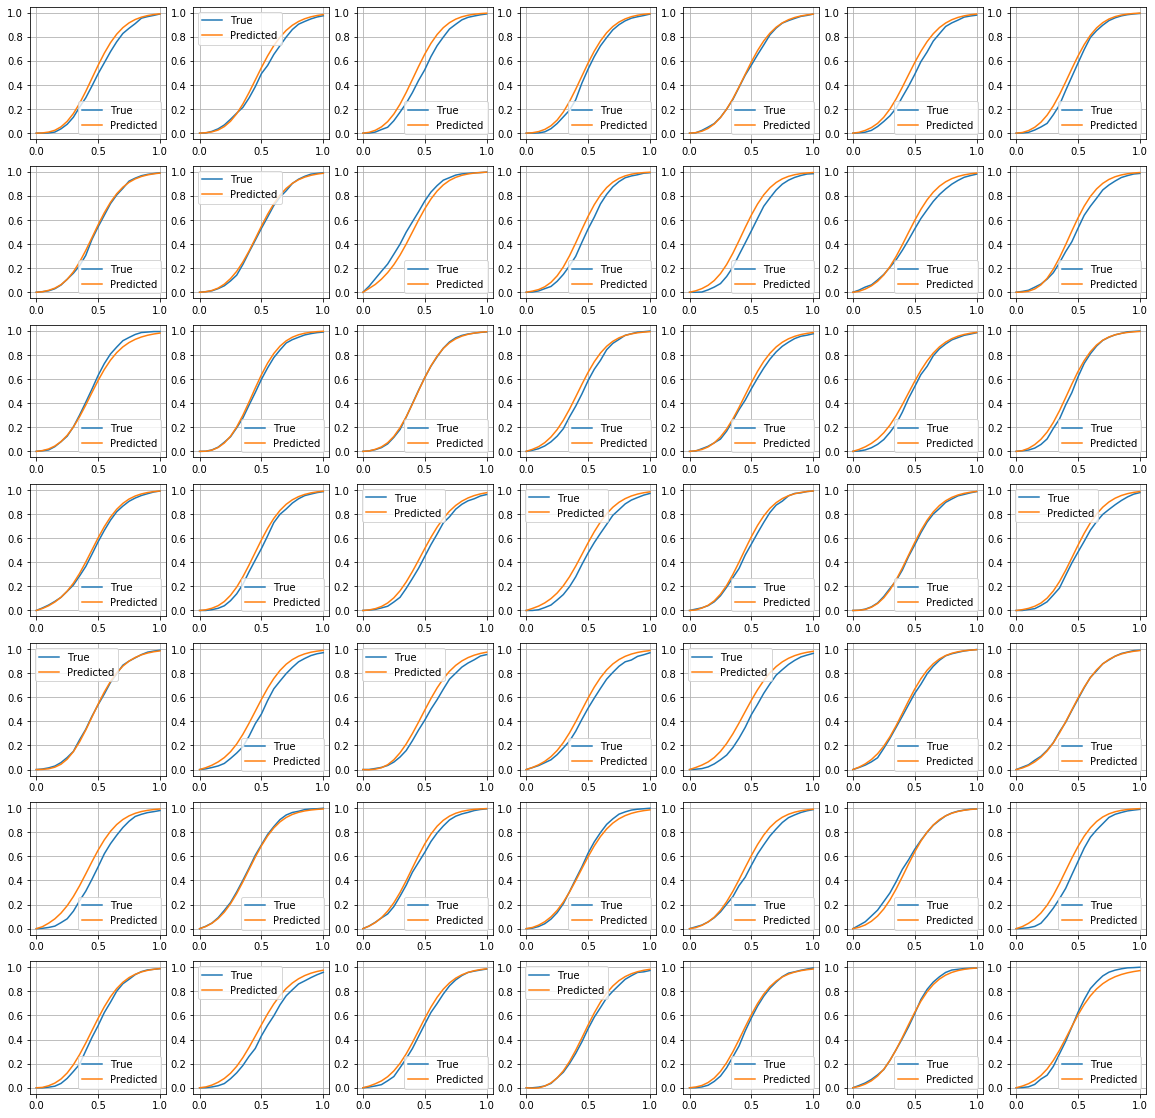

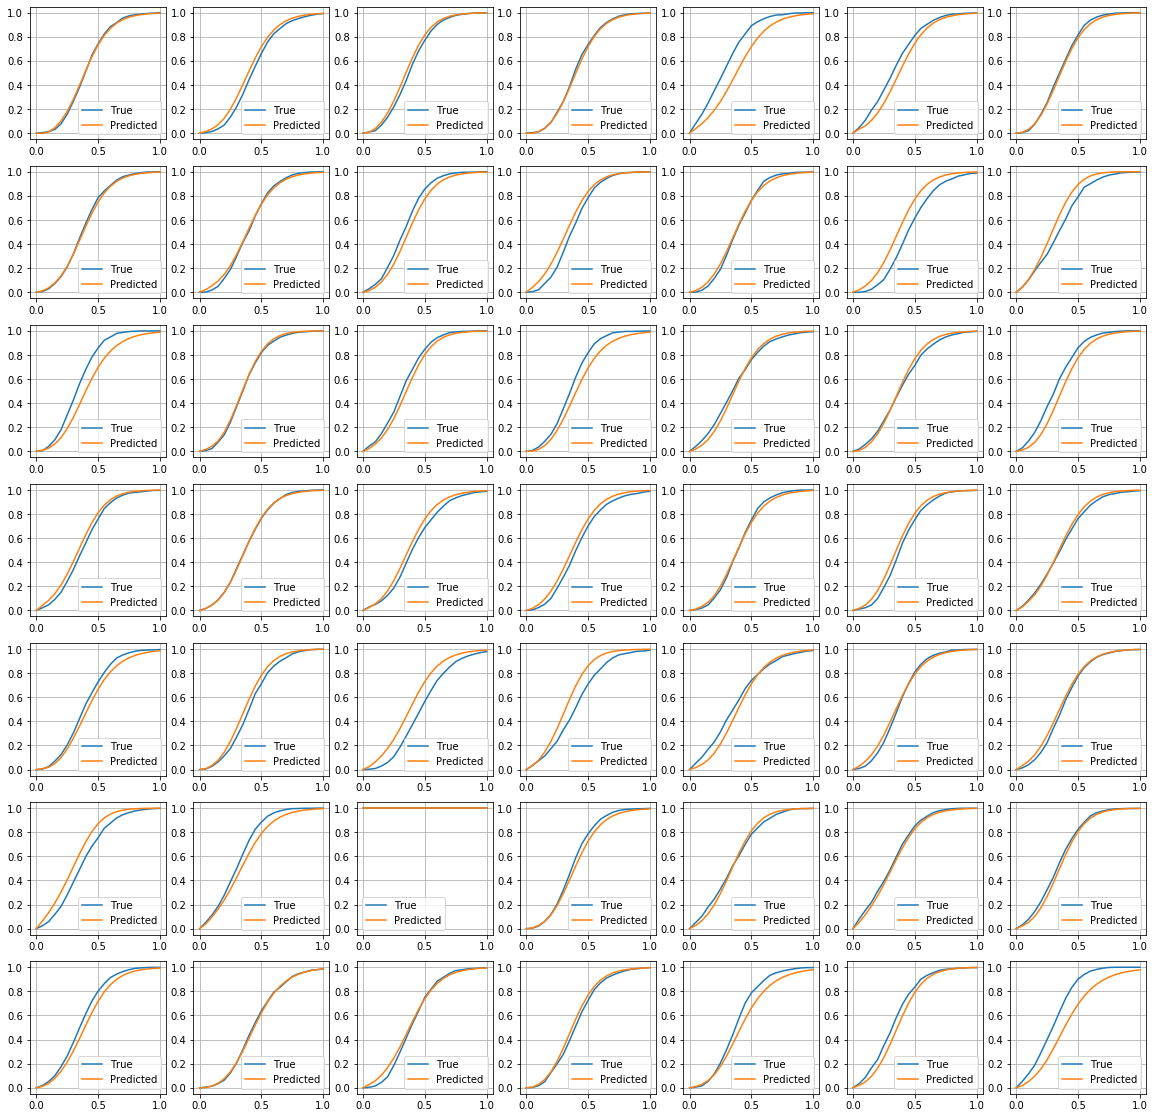

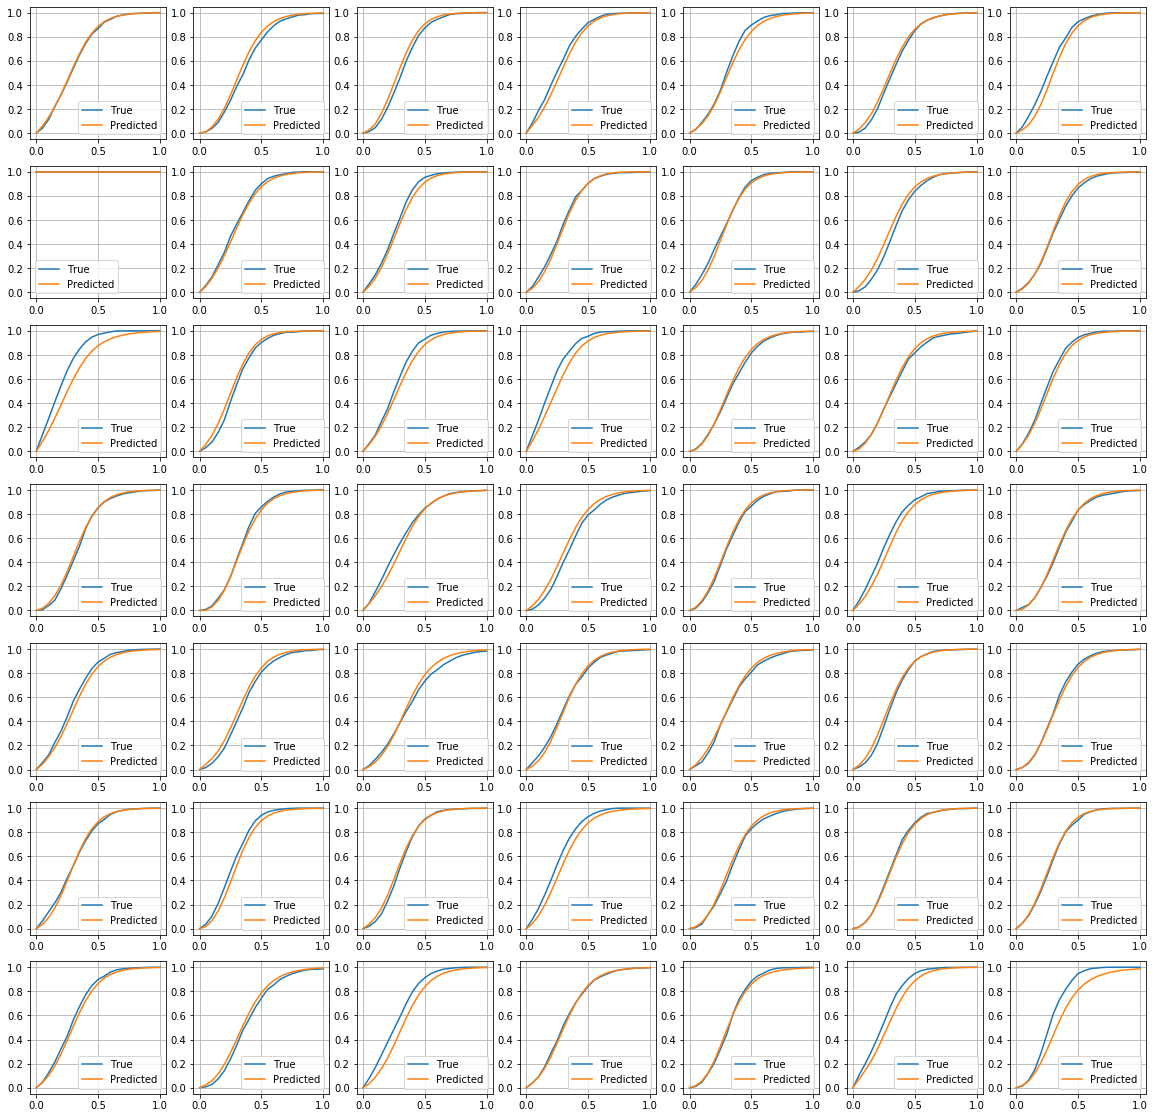

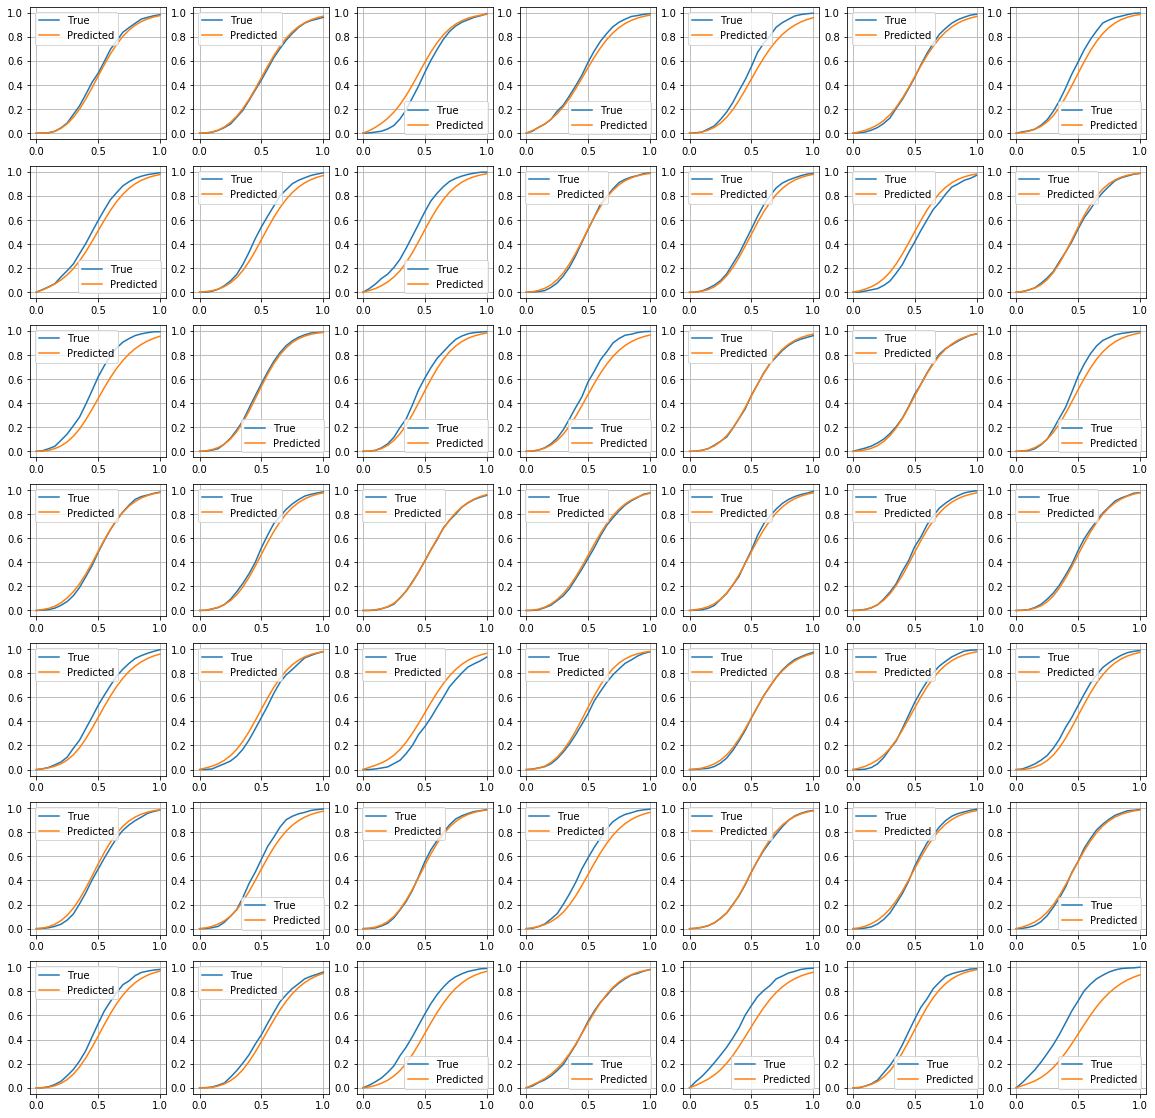

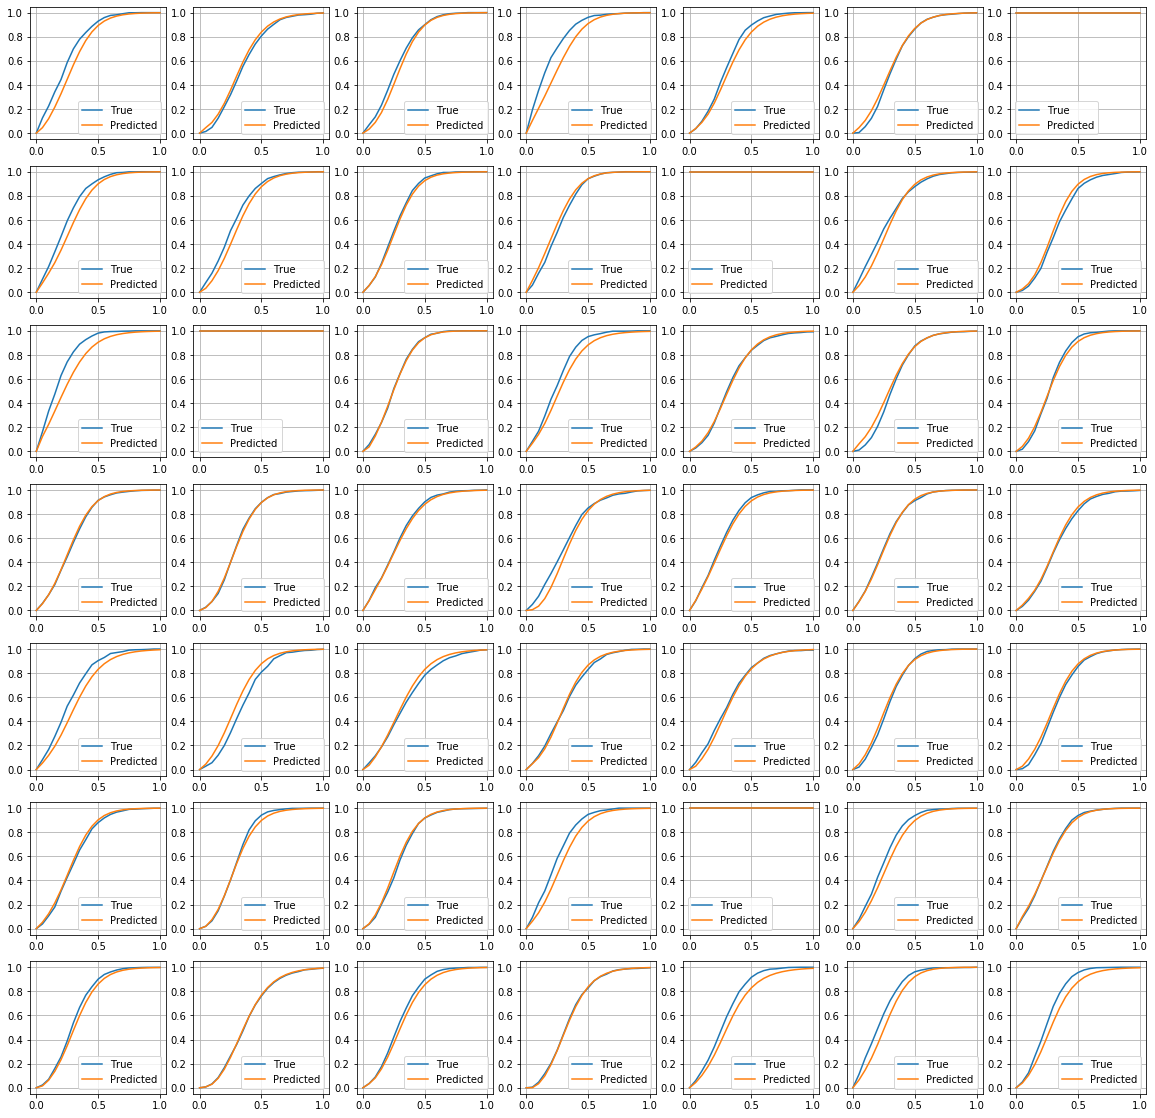

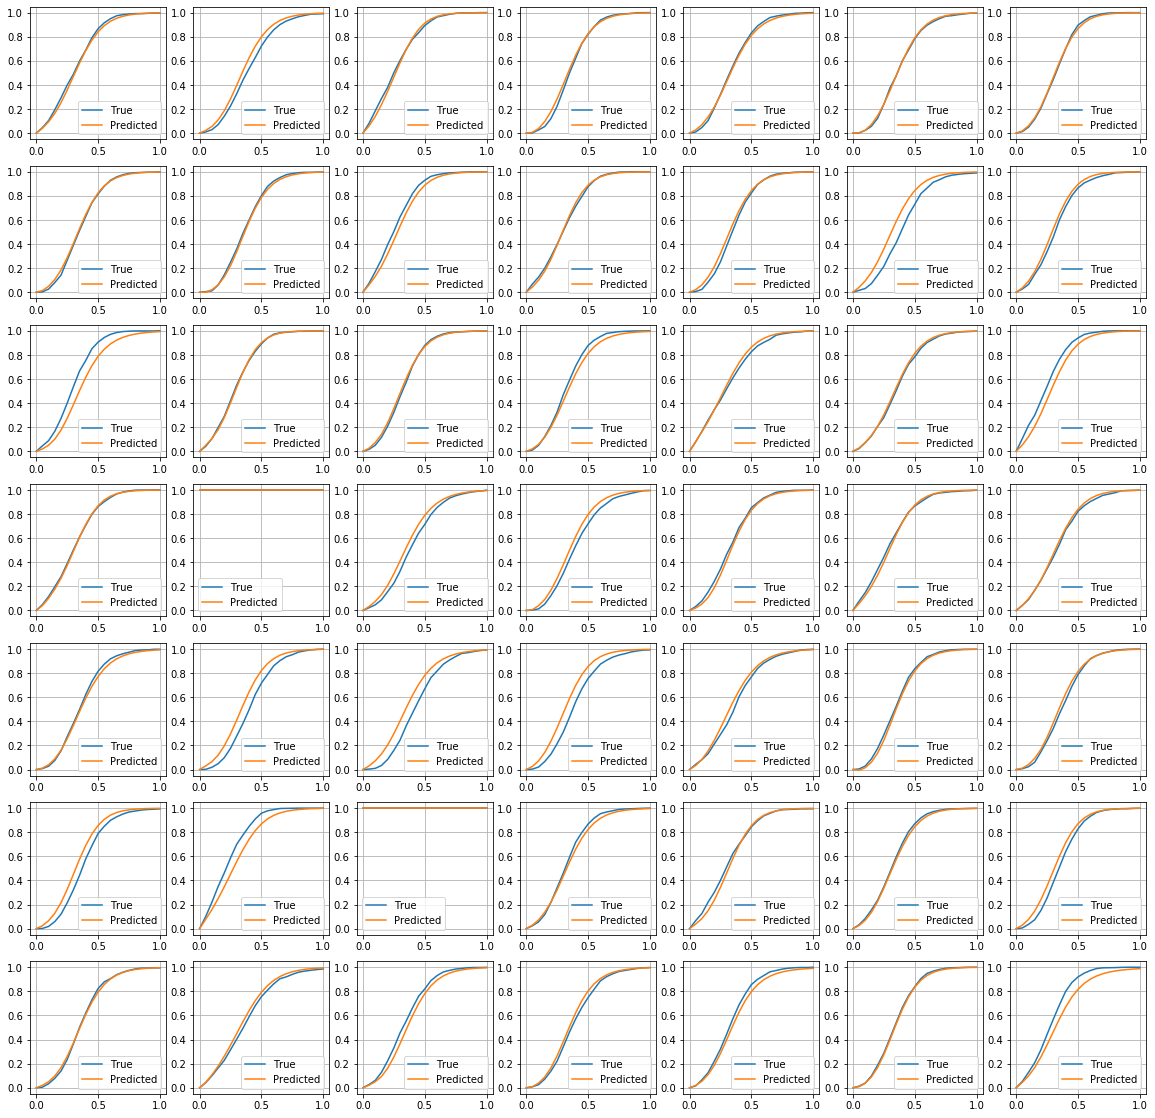

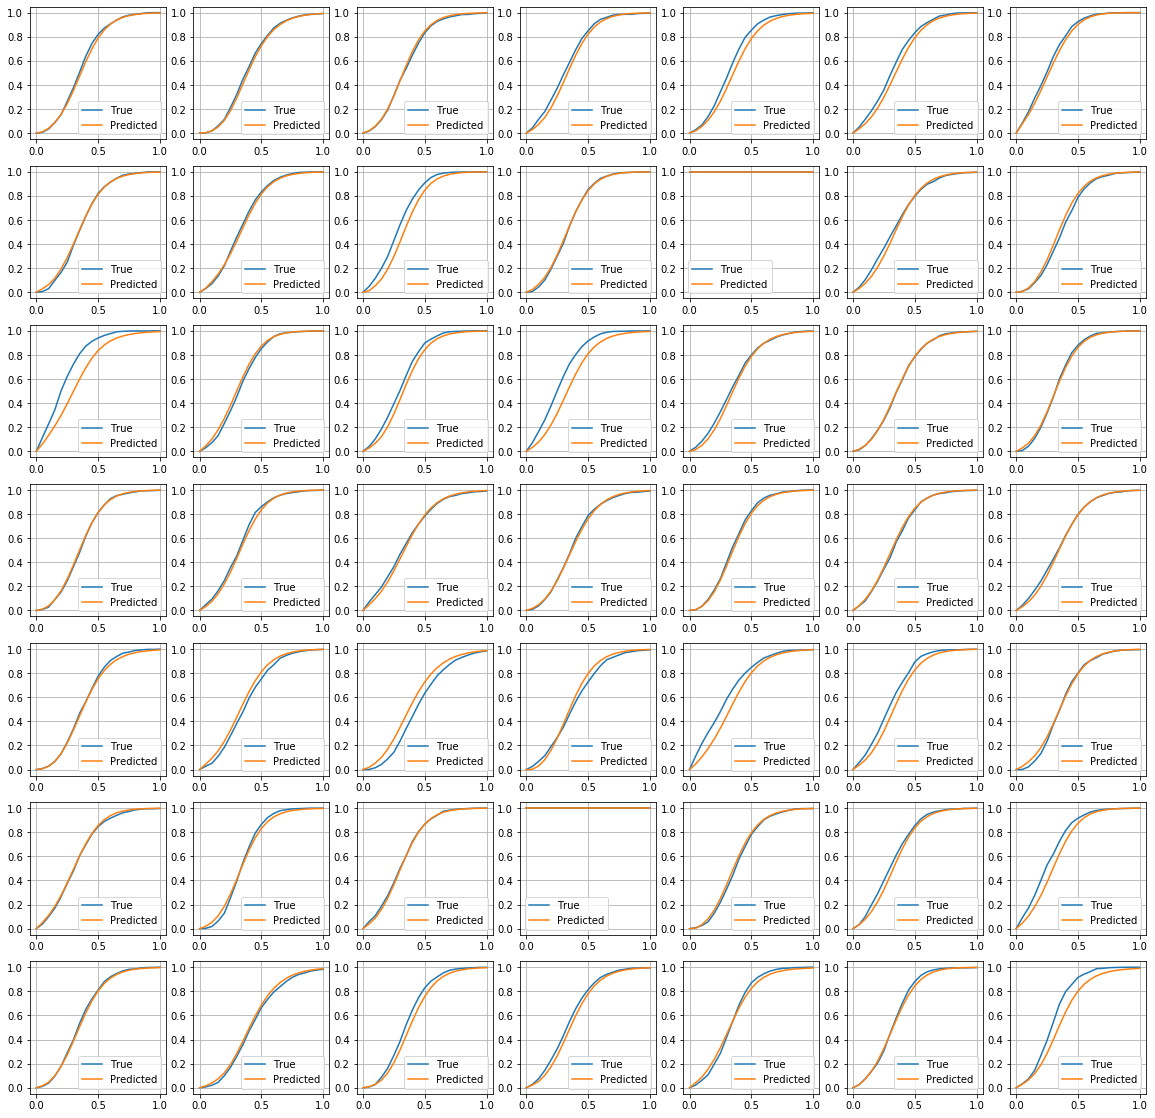

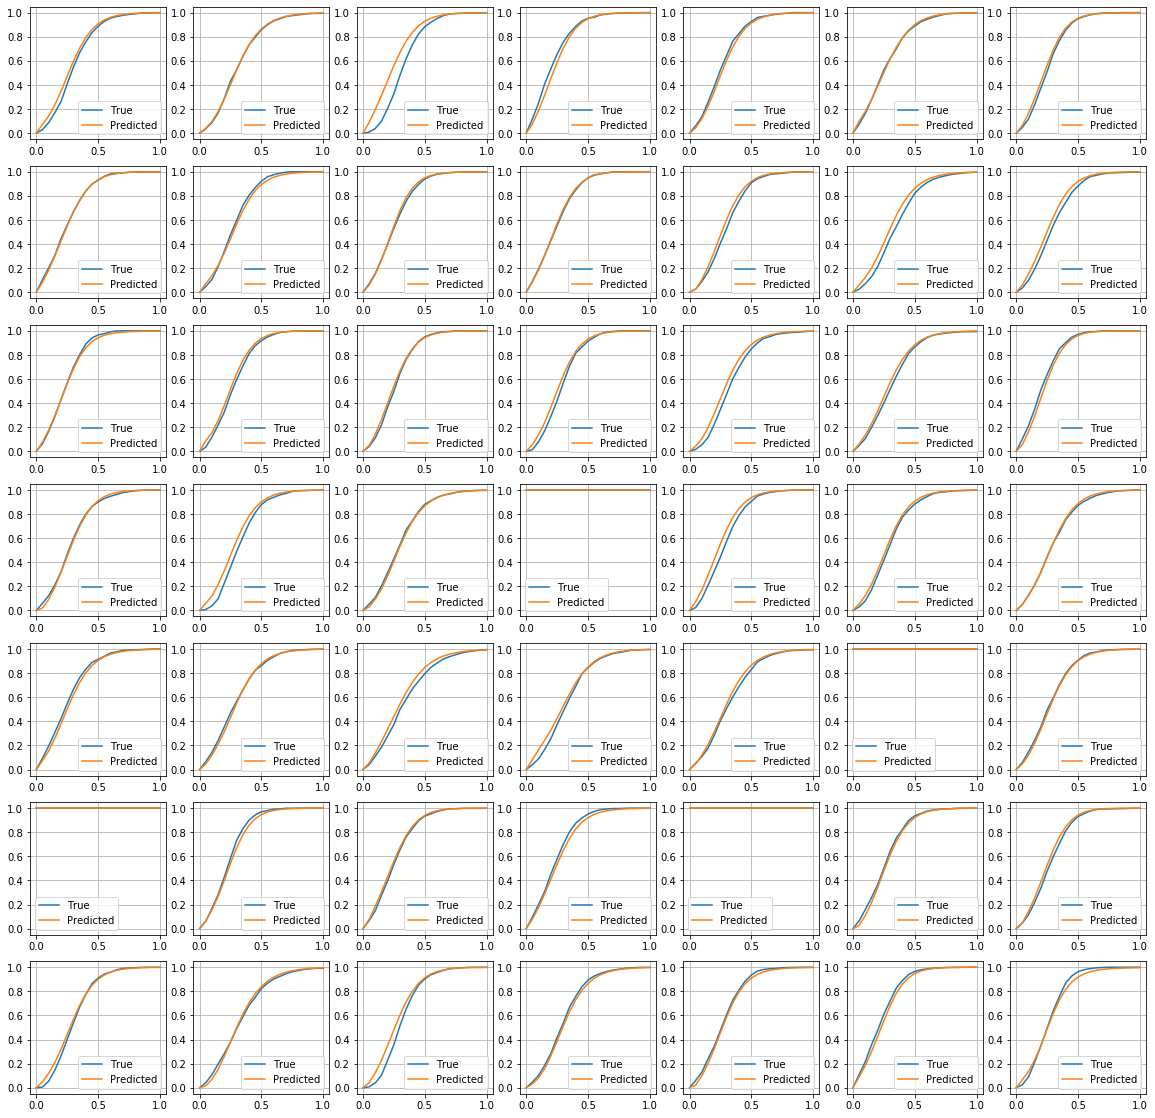

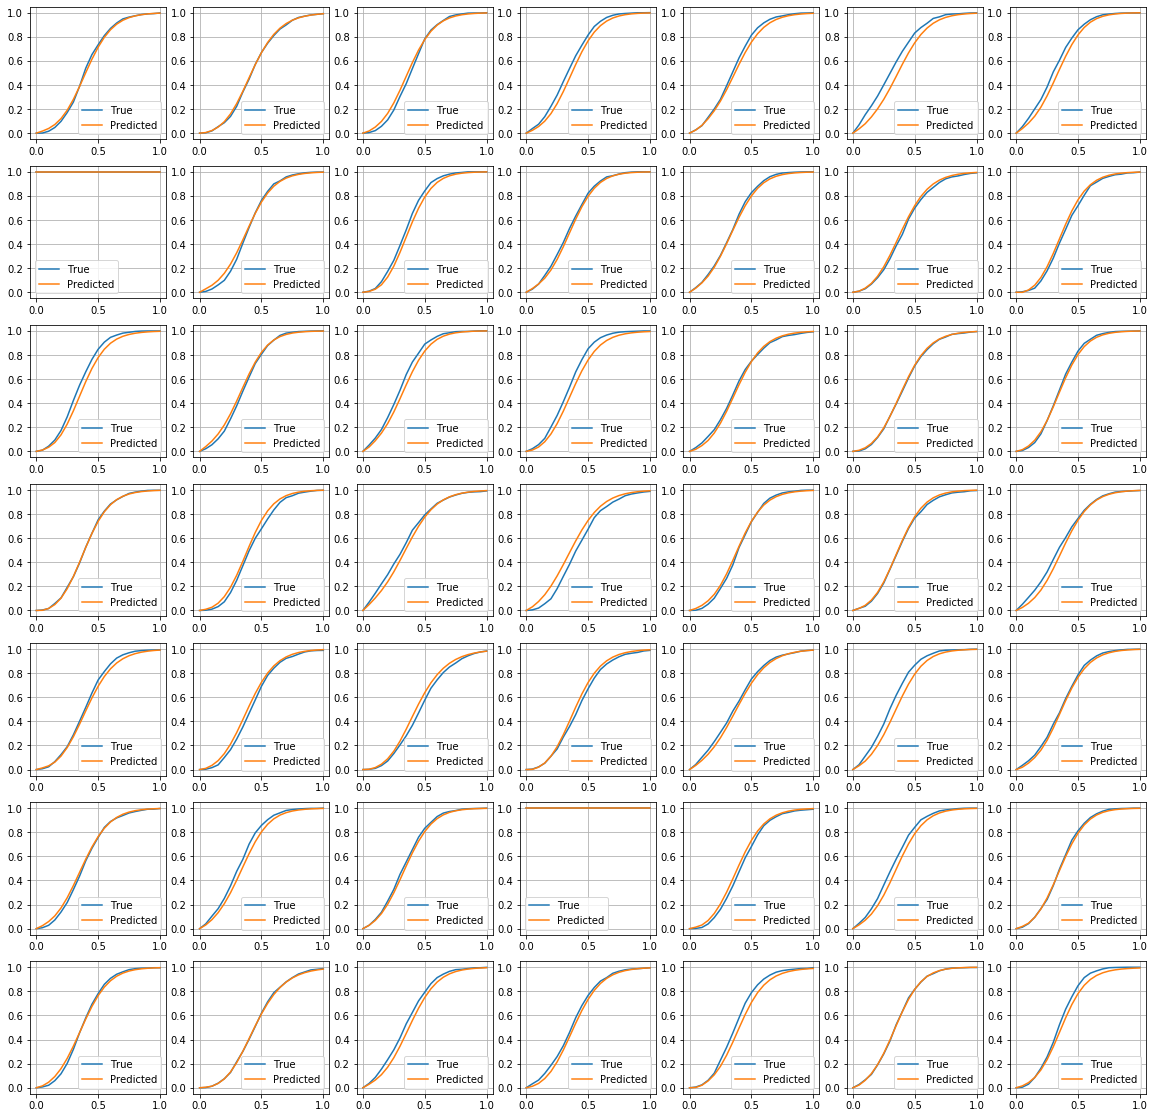

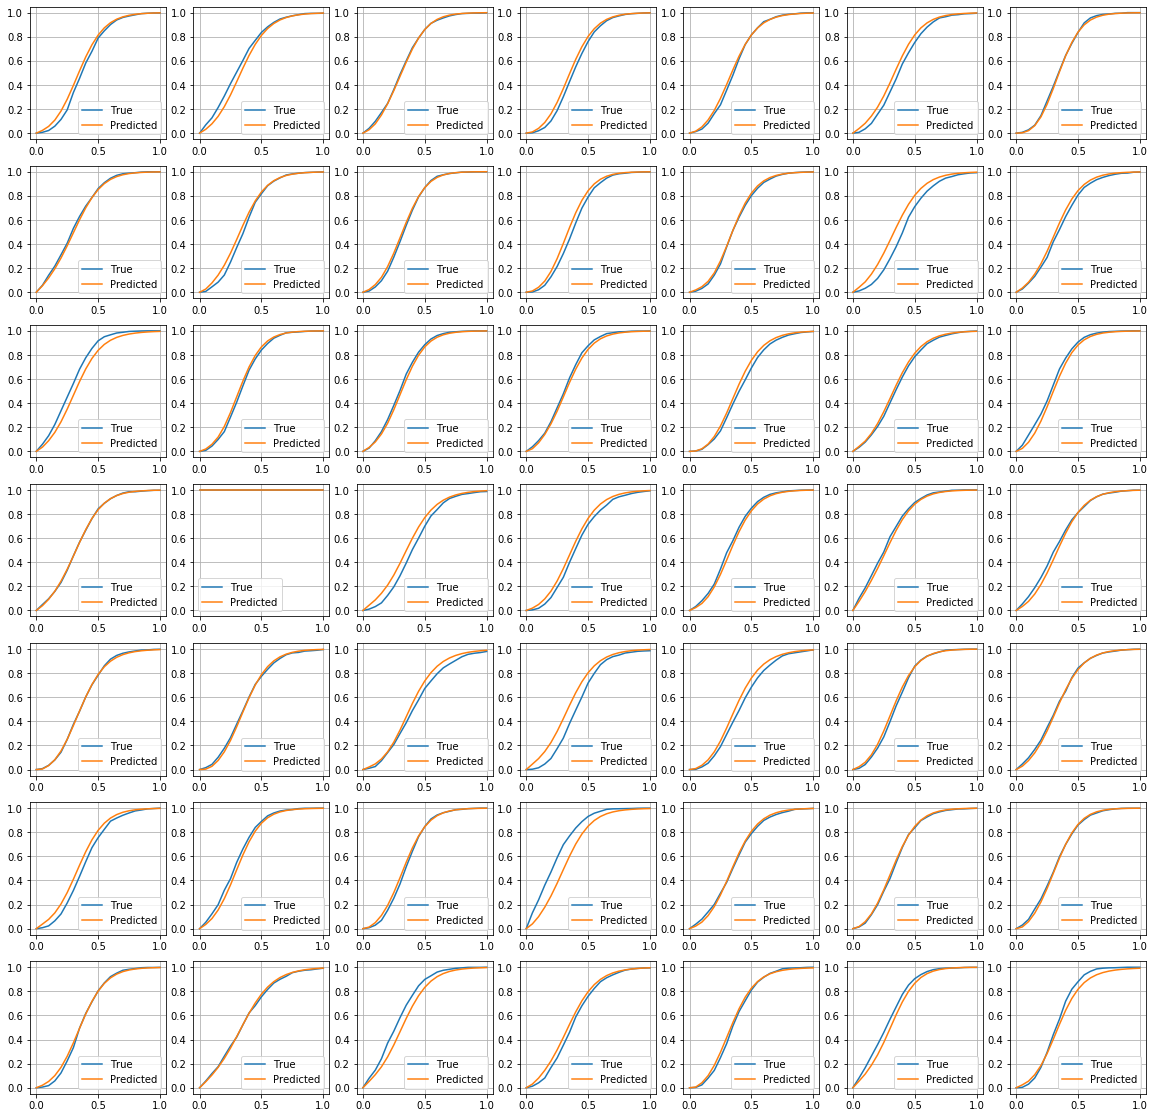

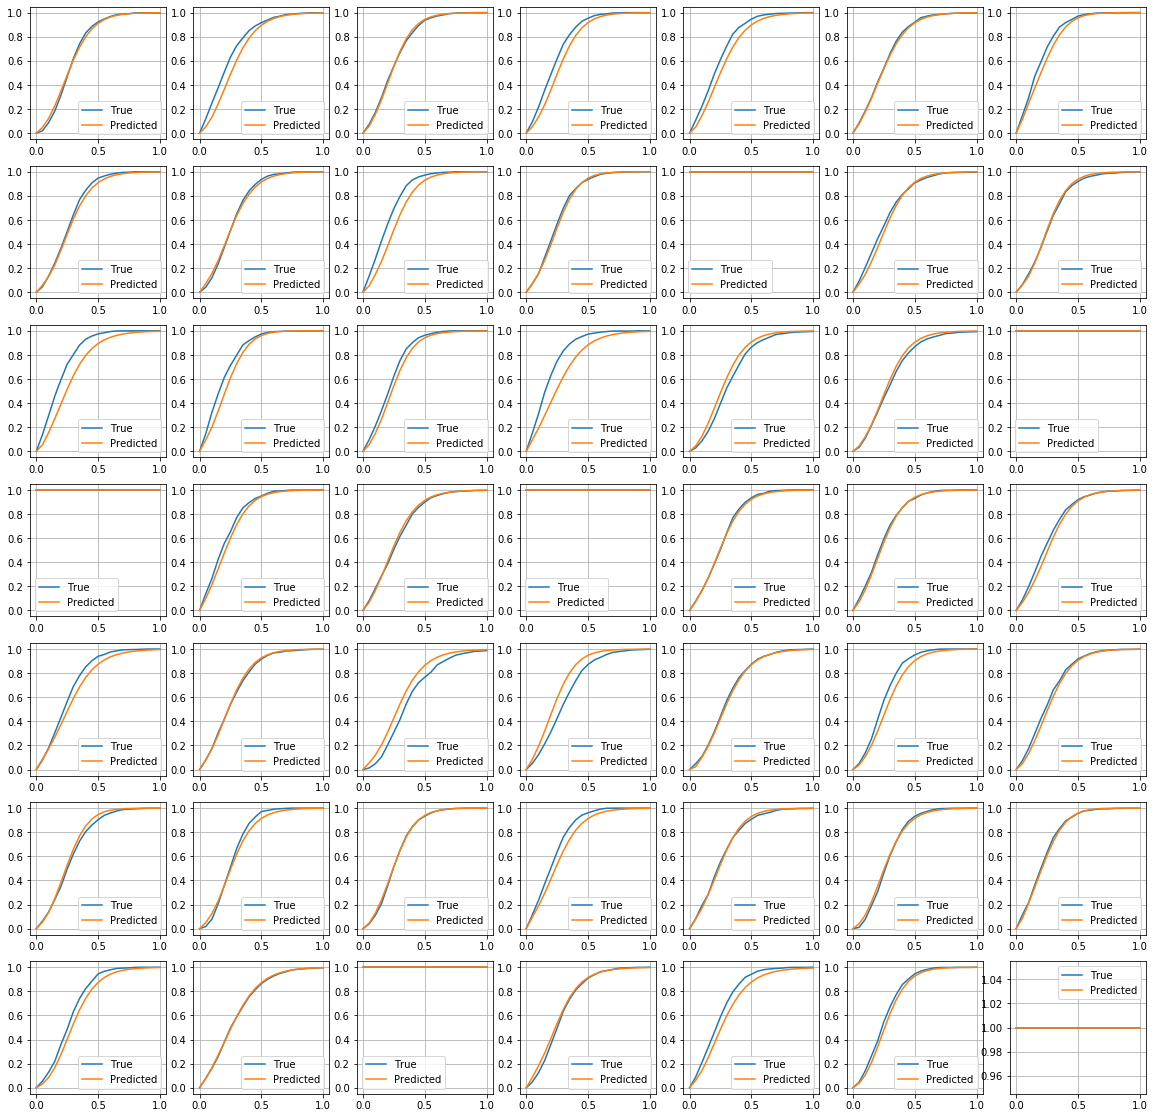

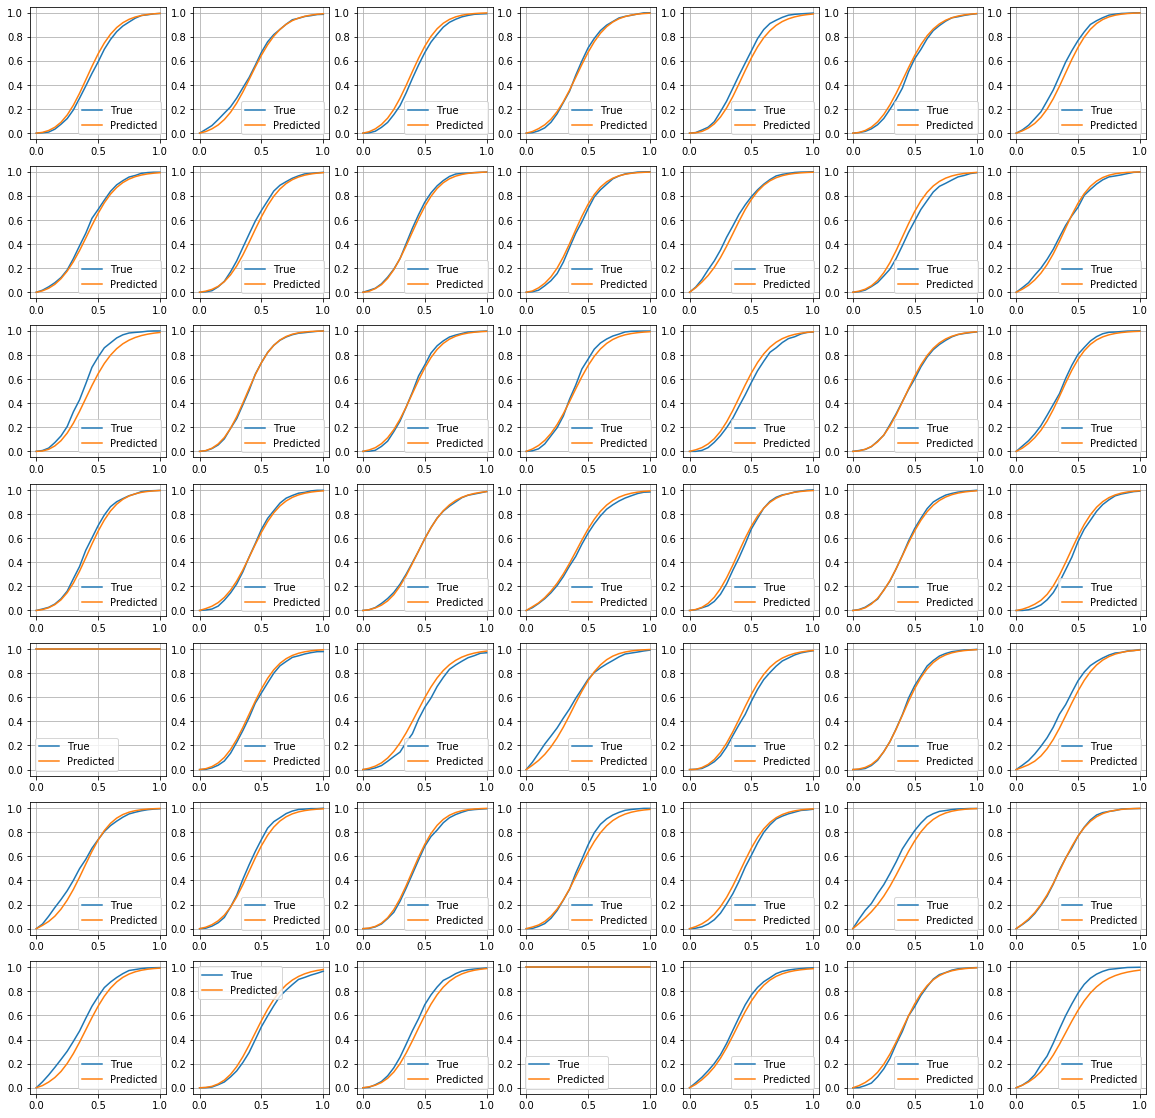

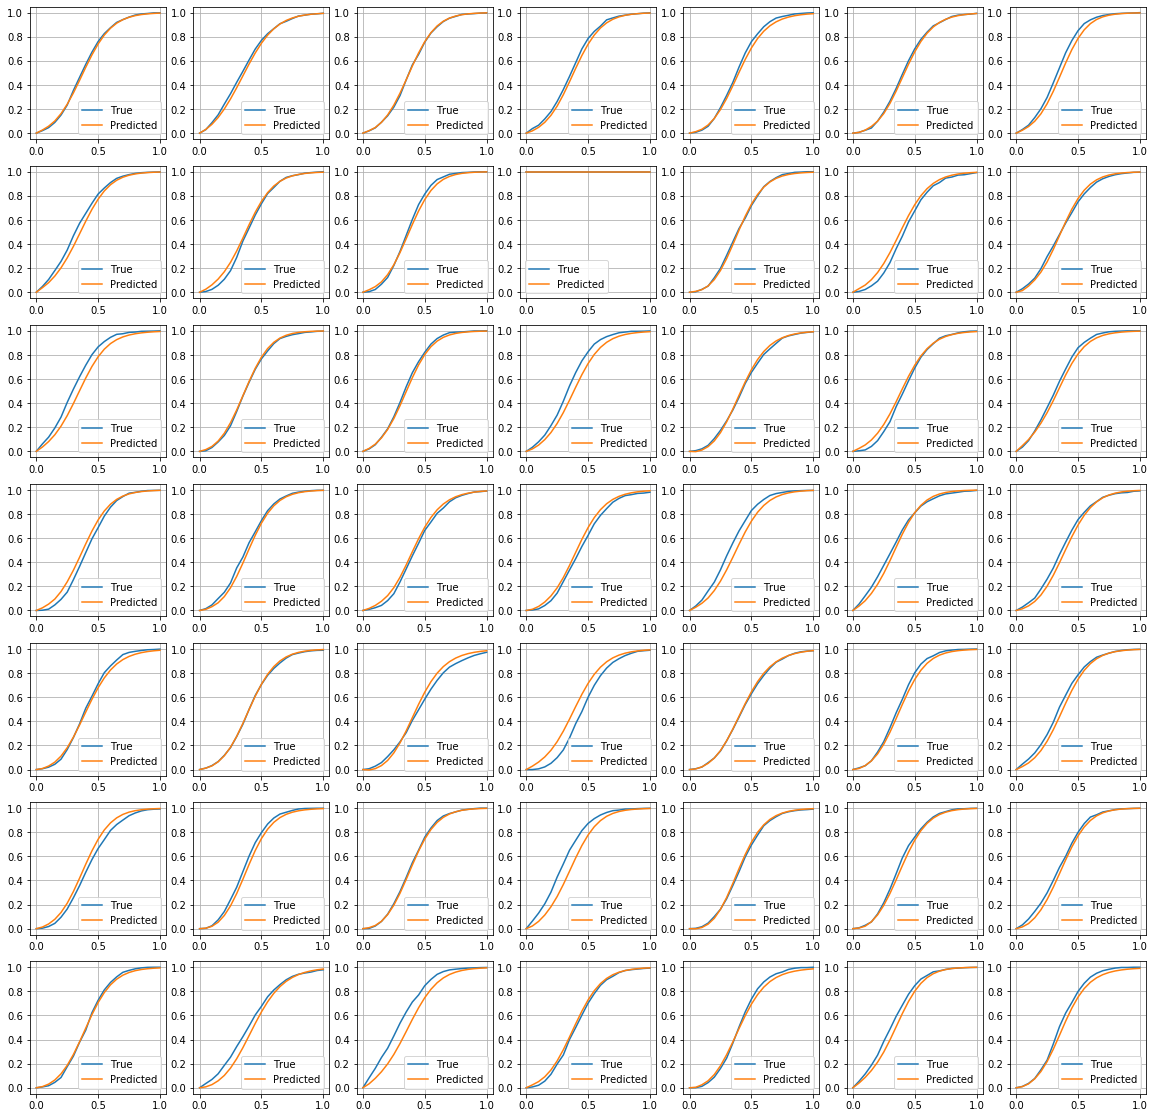

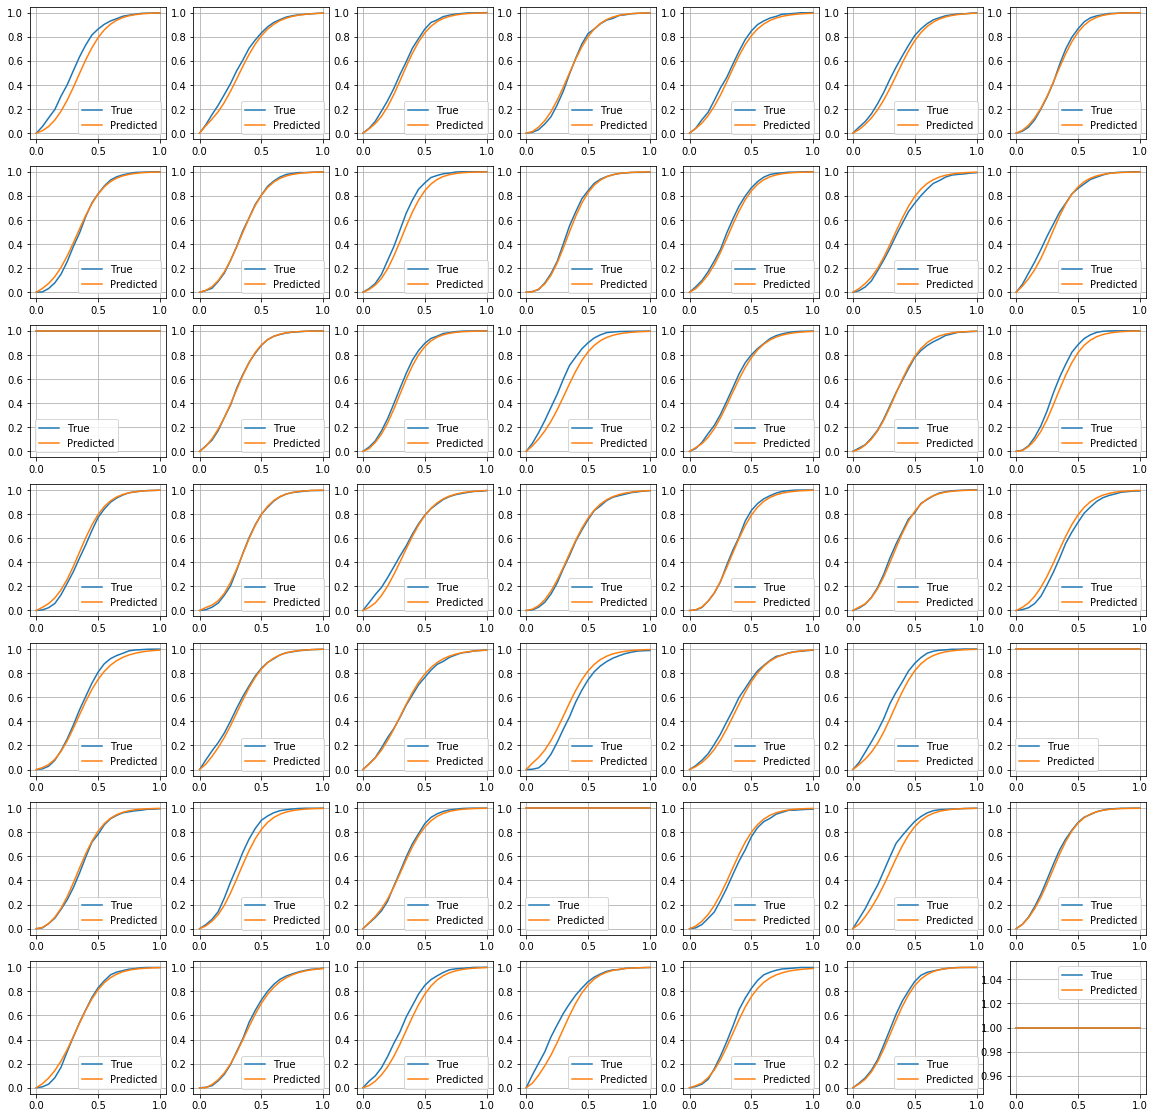

In [0]:
num_examples = 15

for example_idx in range(num_examples):
  Y_true = dataset_test[example_idx, :, :].detach().cpu()
  Y_true = Y_true.detach().numpy()
  num_timesteps = Y_true.shape[0]
  Y_pred = predict_seq(dataset_test[example_idx,0,:], num_timesteps)
  bin_idxs = Y_pred[0,:].shape[0]

  dt=1/20
  t=np.arange(0,1+dt,dt)

  fig=plt.figure(figsize=(20,20))
  for i in range(49):
    true_p = Y_true[:,i]
    pred_p = Y_pred[:,i]
    plt.ylim(-0.05, 1.05)
    plt.subplot(7,7,(i+1))
    plt.plot(t, true_p, label='True')
    plt.plot(t, pred_p, label='Predicted')
    plt.legend(loc='best')
    plt.yscale('linear')
    
    #plt.title('Node_'+str(example_idx+1)+'_'+str(i+1))
    plt.grid(True)
  #plt.savefig('Sample'+str(example_idx+1)+'.png')
  #plt.close(fig)

In [0]:
torch.save(forward_pass.parameters(), 'net_parameters.py')

TypeError: ignored